In [1]:
import pandas as pd

# Load the merged log data with categories
data_path = "C:/dangoal25/data/clean_log_data_with_categories.csv"
data = pd.read_csv(data_path)

print("Data loaded successfully.")

Data loaded successfully.


In [2]:
# Count views and orders per customer per category
view_counts = data[data['inter'] == 'view'].groupby(['user_id', 'bd_item_lcls_cd', 'bd_item_lcls_nm']).size().reset_index(name='view_count')
order_counts = data[data['inter'] == 'order'].groupby(['user_id', 'bd_item_lcls_cd', 'bd_item_lcls_nm']).size().reset_index(name='order_count')

print("View and order counts calculated.")

View and order counts calculated.


In [3]:
# Identify repurchases (order_count >= 2)
reorders = order_counts[order_counts['order_count'] >= 2].groupby(['bd_item_lcls_cd', 'bd_item_lcls_nm']).size().reset_index(name='reorder_count')

# Calculate the total number of unique customers per category
total_customers = order_counts.groupby(['bd_item_lcls_cd', 'bd_item_lcls_nm']).user_id.nunique().reset_index(name='total_customers')

# Merge to calculate repurchase rate
repurchase_data = pd.merge(reorders, total_customers, on=['bd_item_lcls_cd', 'bd_item_lcls_nm'])
repurchase_data['repurchase_rate'] = repurchase_data['reorder_count'] / repurchase_data['total_customers']

print("Repurchase rate calculated by category.")

Repurchase rate calculated by category.


In [4]:
# Merge view counts with order counts
combined_data = pd.merge(view_counts, order_counts, on=['user_id', 'bd_item_lcls_cd', 'bd_item_lcls_nm'], how='outer').fillna(0)

# Merge with repurchase data to add repurchase rates
combined_data = pd.merge(combined_data, repurchase_data[['bd_item_lcls_cd', 'bd_item_lcls_nm', 'repurchase_rate']], on=['bd_item_lcls_cd', 'bd_item_lcls_nm'], how='left').fillna(0)

print("Combined data prepared for analysis.")

Combined data prepared for analysis.


In [5]:
# View count summary
view_summary = combined_data.groupby('bd_item_lcls_nm')['view_count'].sum().reset_index(name='total_view_count')

# Order count summary
order_summary = combined_data.groupby('bd_item_lcls_nm')['order_count'].sum().reset_index(name='total_order_count')

# Repurchase rate summary
repurchase_summary = combined_data.groupby('bd_item_lcls_nm')['repurchase_rate'].mean().reset_index(name='average_repurchase_rate')

# Merge all summaries into a single table for easy reference
summary_table = view_summary.merge(order_summary, on='bd_item_lcls_nm')
summary_table = summary_table.merge(repurchase_summary, on='bd_item_lcls_nm')

# Display the final summary table
summary_table.columns = ['Category', 'Total View Count', 'Total Order Count', 'Average Repurchase Rate']
summary_table

,Category,Total View Count,Total Order Count,Average Repurchase Rate
0,FreshFood,7759336.0,115122.0,0.396954
1,간편식품,8820666.0,55628.0,0.245495
2,과일,1000308.0,8977.0,0.170732
3,과자,5180014.0,53603.0,0.223039
4,냉장식품,1810477.0,10903.0,0.185033
5,밀키트,64632.0,247.0,0.109589
6,뷰티,60613.0,434.0,0.089005
7,빙과류,2669204.0,29756.0,0.185763
8,서비스,240287.0,11236.0,0.167852
9,세트,532311.0,24577.0,0.291835


In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # Windows의 경우
# plt.rc('font', family='AppleGothic')  # Mac의 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

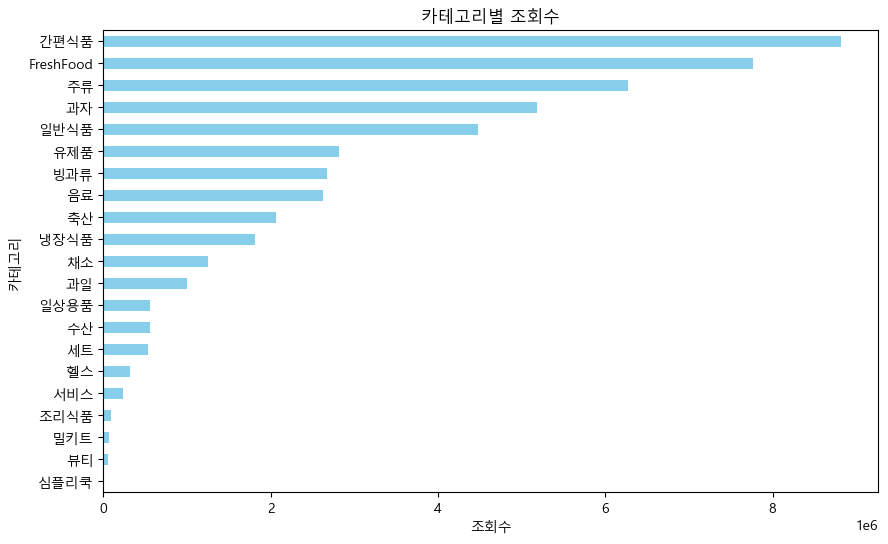

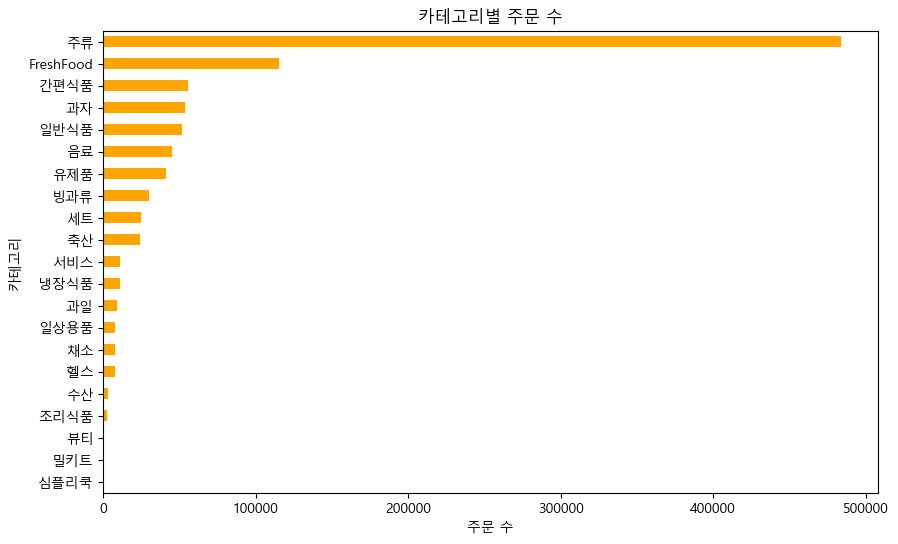

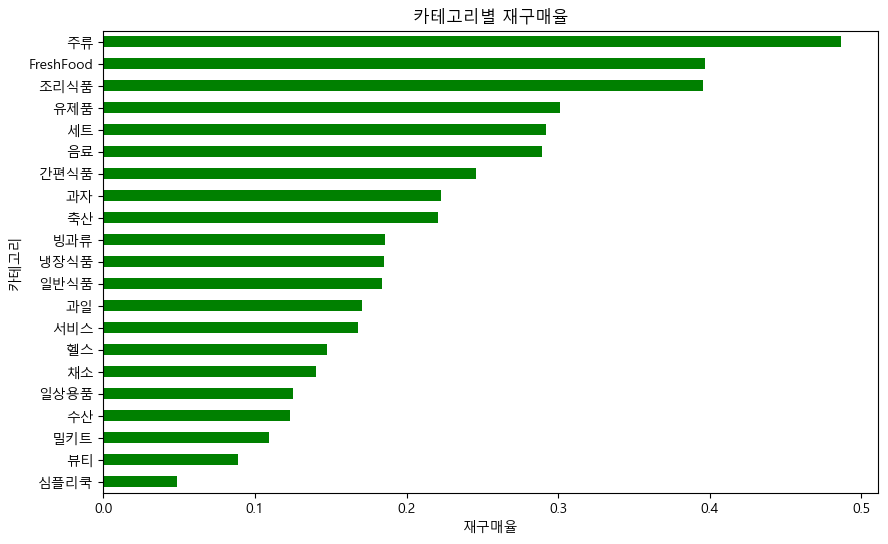

In [7]:
# Plot view count by category
plt.figure(figsize=(10, 6))
view_summary = combined_data.groupby('bd_item_lcls_nm')['view_count'].sum().sort_values()
view_summary.plot(kind='barh', color='skyblue')
plt.xlabel("조회수")
plt.ylabel("카테고리")
plt.title("카테고리별 조회수")
plt.show()

# Plot order count by category
plt.figure(figsize=(10, 6))
order_summary = combined_data.groupby('bd_item_lcls_nm')['order_count'].sum().sort_values()
order_summary.plot(kind='barh', color='orange')
plt.xlabel("주문 수")
plt.ylabel("카테고리")
plt.title("카테고리별 주문 수")
plt.show()

# Plot repurchase rate by category
plt.figure(figsize=(10, 6))
repurchase_summary = combined_data.groupby('bd_item_lcls_nm')['repurchase_rate'].mean().sort_values()
repurchase_summary.plot(kind='barh', color='green')
plt.xlabel("재구매율")
plt.ylabel("카테고리")
plt.title("카테고리별 재구매율")
plt.show()

In [8]:
# Define thresholds for repurchase analysis
thresholds = [5, 10, 20, 30]

# Step 1: Calculate repurchase counts for each threshold
repurchase_data = []
for threshold in thresholds:
    # Identify customers with order_count >= threshold for each category
    threshold_reorders = combined_data[combined_data['order_count'] >= threshold]
    reorder_counts = threshold_reorders.groupby(['bd_item_lcls_cd', 'bd_item_lcls_nm']).size().reset_index(name=f'repurchase_{threshold}_count')
    
    # Count total unique customers per category
    total_customers = combined_data.groupby(['bd_item_lcls_cd', 'bd_item_lcls_nm']).user_id.nunique().reset_index(name='total_customers')
    
    # Merge repurchase counts with total customers and calculate repurchase rate
    threshold_repurchase = pd.merge(reorder_counts, total_customers, on=['bd_item_lcls_cd', 'bd_item_lcls_nm'], how='left')
    threshold_repurchase[f'repurchase_rate_{threshold}'] = threshold_repurchase[f'repurchase_{threshold}_count'] / threshold_repurchase['total_customers']
    
    # Append the result
    repurchase_data.append(threshold_repurchase[['bd_item_lcls_nm', f'repurchase_rate_{threshold}']])

# Step 2: Merge all threshold results into a single DataFrame for easier comparison
repurchase_summary = repurchase_data[0]
for i in range(1, len(repurchase_data)):
    repurchase_summary = pd.merge(repurchase_summary, repurchase_data[i], on='bd_item_lcls_nm', how='outer').fillna(0)

# Rename columns for readability
repurchase_summary.columns = ['Category', 'Repurchase Rate (5+)', 'Repurchase Rate (10+)', 'Repurchase Rate (20+)', 'Repurchase Rate (30+)']

# Display the final summary table
repurchase_summary

,Category,Repurchase Rate (5+),Repurchase Rate (10+),Repurchase Rate (20+),Repurchase Rate (30+)
0,FreshFood,0.008744,0.003135,0.000950,0.000386
1,간편식품,0.001379,0.000243,0.000037,0.000012
2,과일,0.000344,0.000049,0.000013,0.000004
3,과자,0.001316,0.000403,0.000174,0.000118
4,냉장식품,0.000381,0.000053,0.000009,0.000003
5,뷰티,0.000074,0.000037,0.000000,0.000000
6,빙과류,0.000567,0.000097,0.000019,0.000013
7,서비스,0.000693,0.000069,0.000035,0.000017
8,세트,0.002875,0.000328,0.000013,0.000000
9,수산,0.000086,0.000000,0.000000,0.000000


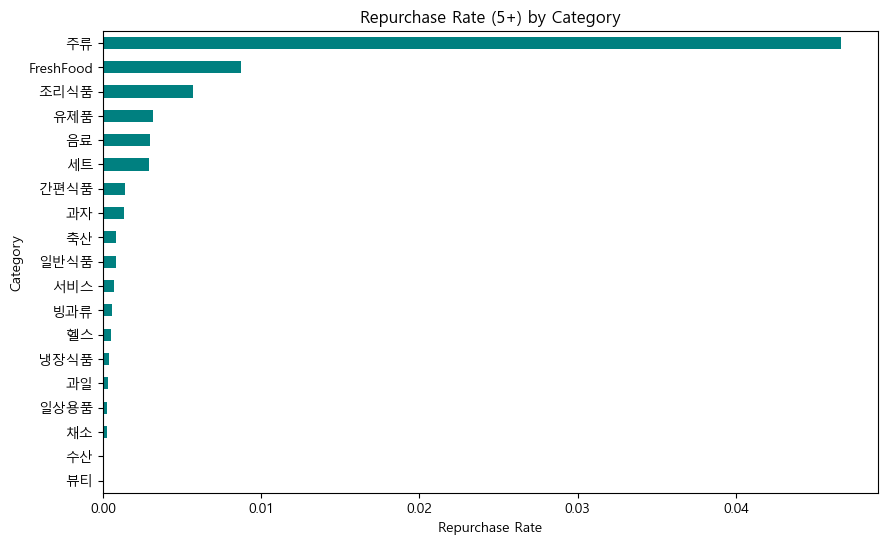

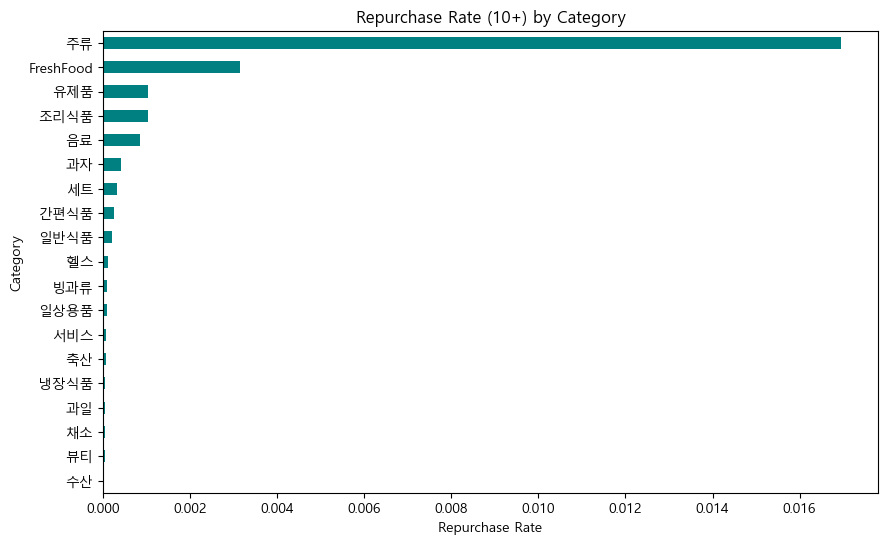

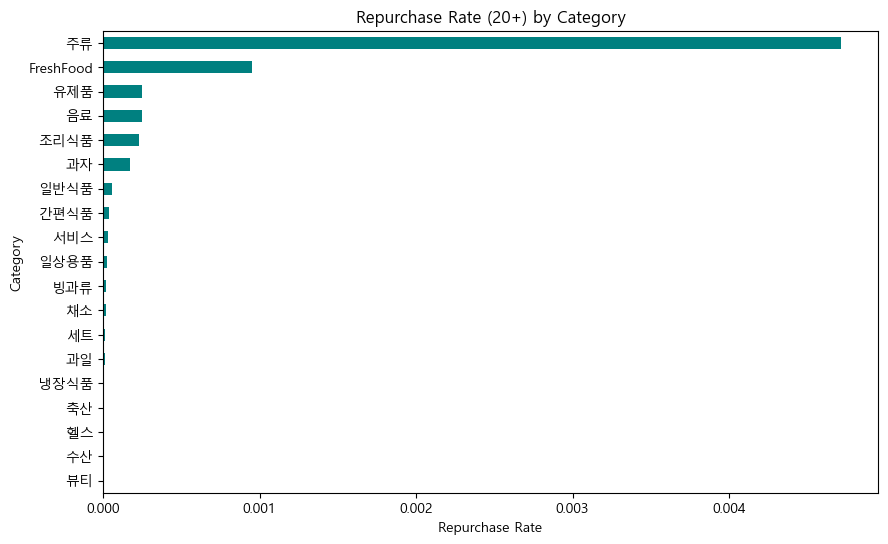

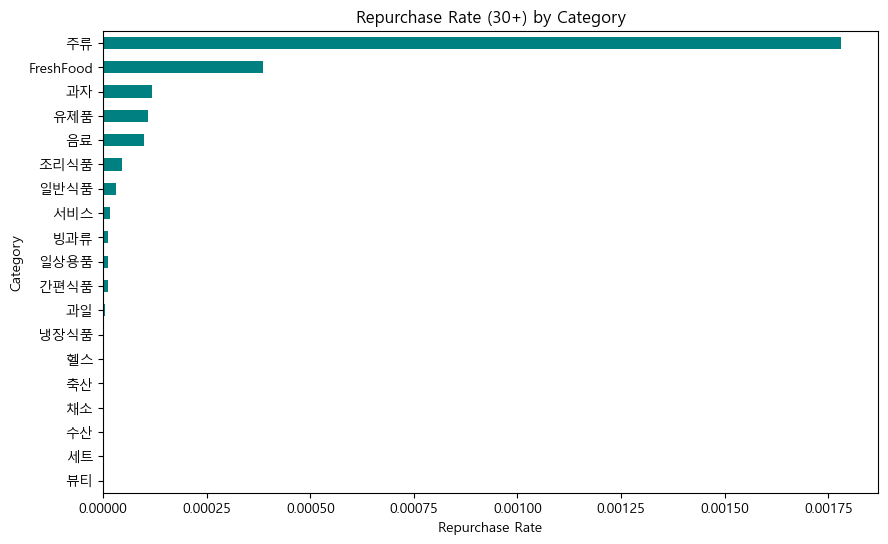

In [10]:
import matplotlib.pyplot as plt

# Set Korean font for plots
plt.rc('font', family='Malgun Gothic')  # Windows users
# plt.rc('font', family='AppleGothic')  # Mac users
plt.rcParams['axes.unicode_minus'] = False

# Plot for each threshold
thresholds = ['Repurchase Rate (5+)', 'Repurchase Rate (10+)', 'Repurchase Rate (20+)', 'Repurchase Rate (30+)']

# Create a separate plot for each threshold
for threshold in thresholds:
    plt.figure(figsize=(10, 6))
    repurchase_summary.set_index('Category')[threshold].sort_values().plot(kind='barh', color='teal')
    plt.xlabel("Repurchase Rate")
    plt.ylabel("Category")
    plt.title(f"{threshold} by Category")
    plt.show()